# Семантическая сегментация

### Задача
Обучить сиамскую сеть для верификации лиц на датасете LFW
<br>
Библиотеки: [Python, Tensorflow]

### Решение

In [1]:
import os
import skimage.io as io
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds

### Загружаем данные

In [2]:
(train_ds, test_ds), ds_info = tfds.load(
    'lfw', 
    data_dir='.',
    download=True,
    as_supervised=True,
    with_info=True,
    split=['train[:80%]', 'train[-20%:]']
)

In [3]:
print(f'Тренировочных изображений: {len(list(train_ds))}')

Тренировочных изображений: 10586


In [4]:
print(f'Тестовых изображений: {len(list(test_ds))}')

Тестовых изображений: 2647


In [5]:
train_ds.take(1)

<DatasetV1Adapter shapes: ((), (250, 250, 3)), types: (tf.string, tf.uint8)>

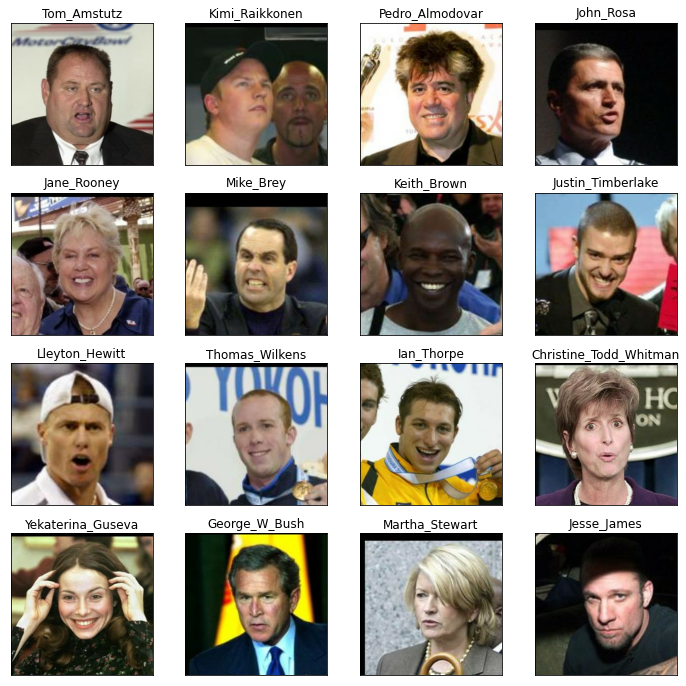

In [6]:
fig = plt.figure(figsize=(12, 12))
for i, data in enumerate(iter(train_ds.take(16))):
    label, image = data
    ax = fig.add_subplot(4, 4, i+1)
    ax.imshow(image)
    ax.set_title(label.numpy().decode())
    plt.xticks([]), plt.yticks([])
plt.show()

### Сверточная нейронная сеть

In [7]:
EMB_SIZE = 64

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(128, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(EMB_SIZE, activation=None),
])

### Функция потерь (Contrastive Loss)

In [8]:
MARGIN = 10.0

def contastive_loss(embs, labels):
    bs = embs.shape[0]
    embs1 = embs[:bs//2, :]
    embs2 = embs[bs//2:, :]
    labels1 = labels[:bs//2]
    labels2 = labels[bs//2:]

    d2 = tf.reduce_sum(tf.square(embs1 - embs2), axis=1)
    d =  tf.sqrt(d2)
    z = tf.cast(labels1 == labels2, tf.float32)
    
    return tf.reduce_mean(z * d2 + (1-z) * tf.maximum(0, MARGIN - d)**2)



### Создание пайплайна данных

In [9]:
BATCH_SIZE = 128
NUM_EPOCHS = 30

train_ds = train_ds.shuffle(buffer_size=len(list(train_ds)), reshuffle_each_iteration=True)
train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(BATCH_SIZE)

### Обучение

In [10]:
optimizer = tf.keras.optimizers.Adam()

In [11]:
%%time

for iteration, (labels, images) in enumerate(train_ds):
    
    # Forward
    images = np.array(images).astype(np.float32) / 255.

    with tf.GradientTape() as tape:
        embs = model(images)
        loss_value = contastive_loss(embs, labels)
        
    # Backward
    grads = tape.gradient(loss_value, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables))

    if iteration % 200 == 0:
        print('[{:>4}] Loss: {:.6f}'.format(iteration, loss_value.numpy()))
        model.save_weights(f'siam_weights_{loss_value.numpy():.4f}.hdf5')

print('[{:>4}] Loss: {:.6f}'.format(iteration, loss_value.numpy()))

[   0] Loss: 91.516144
[ 200] Loss: 0.128742
[ 400] Loss: 0.222038
[ 600] Loss: 01.742364
[ 800] Loss: 0.014303
[1000] Loss: 0.001029
[1200] Loss: 0.076183
[1400] Loss: 0.000783
[1600] Loss: 0.488407
[1800] Loss: 0.090720
[2000] Loss: 0.172732
[2200] Loss: 0.020256
[2400] Loss: 0.256328
[2481] Loss: 0.000000
CPU times: user 4min 41s, sys: 1min 22s, total: 6min 3s
Wall time: 7min 21s


In [12]:
model.save_weights('siam_weights.hdf5')

### Проверка

In [13]:
images3 = list(test_ds.shuffle(buffer_size=len(list(test_ds))).take(3))

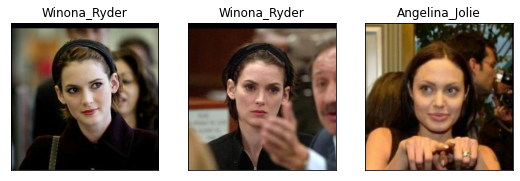

In [14]:
fig = plt.figure(figsize=(9, 3))
for i, (l, im) in enumerate(images3):
    ax = fig.add_subplot(1, 3, i + 1)
    ax.imshow(im)
    ax.set_title(l.numpy().decode())
    plt.xticks([]), plt.yticks([])
plt.show()

### Получение эмбеддингов для новых данных

In [15]:
new_embs = model(np.array([im for _, im in images3]).astype(np.float32) / 255.)

### Вычисление расстояний между эмбеддингами

In [16]:
def diff(e1, e2):
    return np.sum((e1 - e2)**2) ** 0.5

emb1 = new_embs[0,:]
emb2 = new_embs[1,:]
emb3 = new_embs[2,:]

print('A1 <-> A2: ', diff(emb1, emb2))
print('A2 <-> B1: ', diff(emb2, emb3))
print('A1 <-> B1: ', diff(emb1, emb3))

A1 <-> A2:  5.784344149300664
A2 <-> B1:  14.684908764107329
A1 <-> B1:  15.6645461466793

